# Seasonal Autoregressive Integrated Moving Averages - SARIMA(p,d,q)(P,D,Q)

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

Two libraries cover these models - [statsmodels](https://www.statsmodels.org/stable/index.html) and [darts](https://unit8co.github.io/darts/).  This notebook uses statsmodels.

ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting model that combines autoregressive (AR), differencing (I), and moving average (MA) components.

1. **AutoRegressive (AR)**: The AR component of ARIMA models the relationship between an observation and a number of lagged observations (i.e., observations at prior time steps). It captures the linear dependence between the current value and its previous values.

2. **Integrated (I)**: The I component represents differencing of the raw observations to make the time series stationary. Stationarity is essential for many time series forecasting techniques because it ensures that the statistical properties of the series, such as mean and variance, remain constant over time.

3. **Moving Average (MA)**: The MA component of ARIMA models the relationship between an observation and a residual error from a moving average model applied to lagged observations. It captures the relationship between the current value and a stochastic component based on past forecast errors.

ARIMA models are typically denoted by the notation ARIMA(p, d, q), where:
- **p**: The number of lag observations included in the model's autoregressive component.
- **d**: The number of times the raw observations are differenced to achieve stationarity.
- **q**: The size of the moving average window, or the number of lagged forecast errors included in the model's moving average component.

ARIMA models are widely used for time series forecasting in various fields such as economics, finance, meteorology, and engineering. They can be extended to handle seasonality and trends in the data through seasonal ARIMA (SARIMA) models. Parameter selection and model fitting in ARIMA involve statistical techniques like autocorrelation function (ACF) and partial autocorrelation function (PACF) analysis, along with tests for stationarity.

In a Seasonal Autoregressive Integrated Moving Average (SARIMA) model, the parameters extend those of the regular ARIMA model to account for seasonality in the time series data. Here's what each parameter in a SARIMA model typically represents:

1. **p (AR parameter)**: This parameter represents the number of lagged observations included in the model's autoregressive (AR) component, similar to the non-seasonal ARIMA model. It captures the relationship between the current observation and its previous observations within the same season.

2. **d (Integrated parameter)**: This parameter represents the degree of differencing required to make the time series stationary, similar to the non-seasonal ARIMA model.

3. **q (MA parameter)**: This parameter represents the number of lagged forecast errors included in the model's moving average (MA) component, similar to the non-seasonal ARIMA model.

4. **P (Seasonal AR parameter)**: This parameter represents the number of seasonal autoregressive terms, capturing the relationship between the current observation and its previous observations at the same lag in previous seasons.

5. **D (Seasonal Integrated parameter)**: This parameter represents the degree of seasonal differencing required to make the time series stationary, similar to the non-seasonal ARIMA model.

6. **Q (Seasonal MA parameter)**: This parameter represents the number of seasonal moving average terms, capturing the relationship between the current observation and its previous forecast errors at the same lag in previous seasons.

7. **s (Seasonal period)**: This parameter indicates the periodicity of the seasonality in the time series data. It defines the number of observations per seasonal cycle. For example, if the data is monthly and exhibits yearly seasonality, then s would be 12.

So, in summary:

- **p, d, q**: Non-seasonal ARIMA parameters.
- **P, D, Q**: Seasonal ARIMA parameters.
- **s**: Seasonal period.

These parameters are determined through methods like autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, along with seasonal differencing and statistical tests for stationarity. Tuning these parameters effectively is crucial for building an accurate SARIMA model for time series forecasting, especially when dealing with seasonal data patterns.

## LOAD THE LIBRARIES

In [3]:
import pandas as pd
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress specific warning
warnings.filterwarnings("ignore", message="Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated.*")
warnings.filterwarnings("ignore", message="Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.")


## LOAD THE DATA

In [4]:
# Load dataset
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)
df.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,39.7564,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.8,1,fraud_Bradtke PLC,39.817013,-76.261575


## PLOT THE DATA

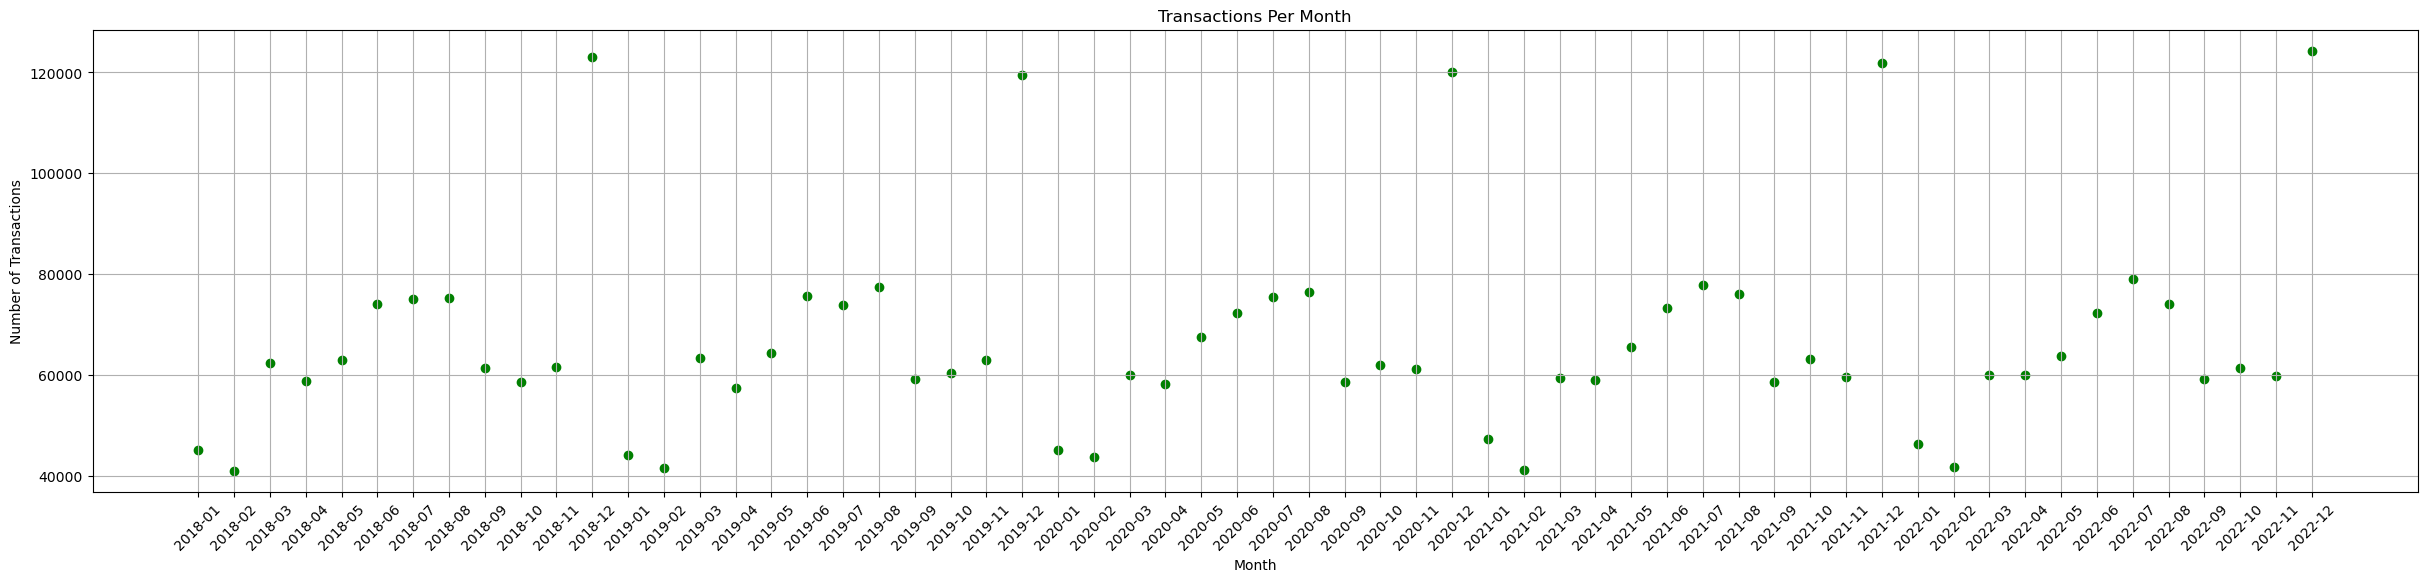

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'trans_date' to datetime format
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Create a new column for the month
df['trans_month'] = df['trans_date'].dt.to_period('M')

# Group by month and count the number of transactions
monthly_transactions = df.groupby('trans_month').size()

# Rename the series
monthly_transactions = monthly_transactions.rename('total_transactions')

# Reset index to make 'trans_month' a column instead of the index
monthly_transactions = monthly_transactions.reset_index()

plt.figure(figsize=(30, 6))
plt.scatter(monthly_transactions['trans_month'].astype(str), monthly_transactions['total_transactions'], color='green')
plt.title('Transactions Per Month')
plt.xlabel('Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


## SET UP DATASET

In [6]:
monthly_transactions.head()

,trans_month,total_transactions
0,2018-01,45218
1,2018-02,41033
2,2018-03,62296
3,2018-04,58907
4,2018-05,63069


In [7]:
daily_transactions = df.groupby('trans_date').size()
daily_transactions.index = pd.to_datetime(daily_transactions.index)
monthly_transactions = daily_transactions.groupby(pd.Grouper(freq='MS')).sum()
monthly_transactions = monthly_transactions.reset_index()
monthly_transactions = monthly_transactions.rename(columns={'trans_date': 'trans_month', 0: 'total_transactions'})

In [8]:
monthly_transactions.head()

,trans_month,total_transactions
0,2018-01-01,45218
1,2018-02-01,41033
2,2018-03-01,62296
3,2018-04-01,58907
4,2018-05-01,63069


In [9]:
monthly_transactions['trans_month'] = pd.to_datetime(monthly_transactions['trans_month'])
monthly_transactions.set_index('trans_month', inplace=True)
monthly_transactions.head()

,total_transactions
trans_month,
2018-01-01,45218
2018-02-01,41033
2018-03-01,62296
2018-04-01,58907
2018-05-01,63069


# Seasonal Decompose

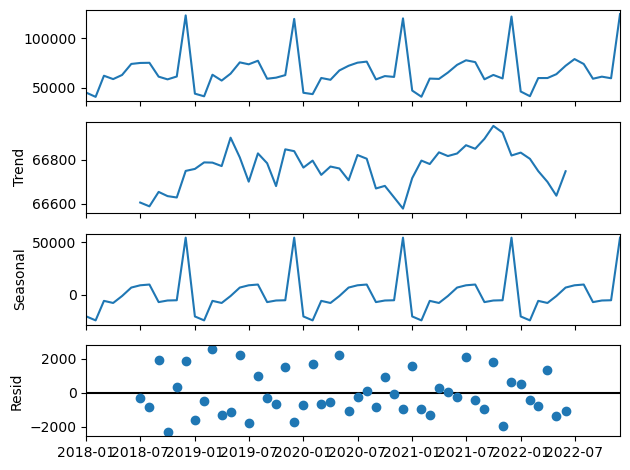

In [10]:
result = seasonal_decompose(monthly_transactions, model='add')
result.plot();

## Parameters m=12

In [11]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(monthly_transactions,seasonal=True,m=12).summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -424.900
Date:                  Mon, 08 Apr 2024   AIC                            851.800
Time:                          14:26:45   BIC                            853.671
Sample:                      01-01-2018   HQIC                           852.507
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.833e+06   7.49e+05      3.781      0.000    1.36e+06     4.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.60   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.51   Skew:                            -0.36
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [12]:
len(monthly_transactions)

60

In [13]:
# Set one month for testing - imporant - use the latest data for the best forecasting
train = monthly_transactions.iloc[:30]
test = monthly_transactions.iloc[30:]
print(len(train))
print(len(test))

30
30


### Train

In [14]:
#monthly model because season = month => m=12
monthly_model = SARIMAX(train,seasonal_order=(0,1,0,12))
monthly_results = monthly_model.fit()
monthly_results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_transactions   No. Observations:                   30
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -162.885
Date:                            Mon, 08 Apr 2024   AIC                            329.771
Time:                                    14:26:45   BIC                            331.552
Sample:                                01-01-2018   HQIC                           330.016
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.089     -0.163      0.871      -0.189       0.160
sigma2      3.185e+06   1.26e+06      2.531      0.011    7.19e+05    5.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.03   Prob(JB):                         0.45
Heteroskedasticity (H):               4.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict

In [15]:
# Obtain predicted values
start=len(train)+1
end=len(train)+len(test)
print(start, end, end-start)

31 60 29


In [16]:
monthly_predictions = monthly_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0,12) Predictions')
monthly_predictions.head()

2020-08-01     77392.282408
2020-09-01     59278.010381
2020-10-01     60352.999850
2020-11-01     62909.000002
2020-12-01    119509.000000
Freq: MS, Name: SARIMA(0,1,0,12) Predictions, dtype: float64

In [17]:
monthly_predictions.tail()

2022-09-01     59278.010381
2022-10-01     60352.999850
2022-11-01     62909.000002
2022-12-01    119509.000000
2023-01-01     45131.000000
Freq: MS, Name: SARIMA(0,1,0,12) Predictions, dtype: float64

In [18]:
print(len(test))
print(len(monthly_predictions))

30
30


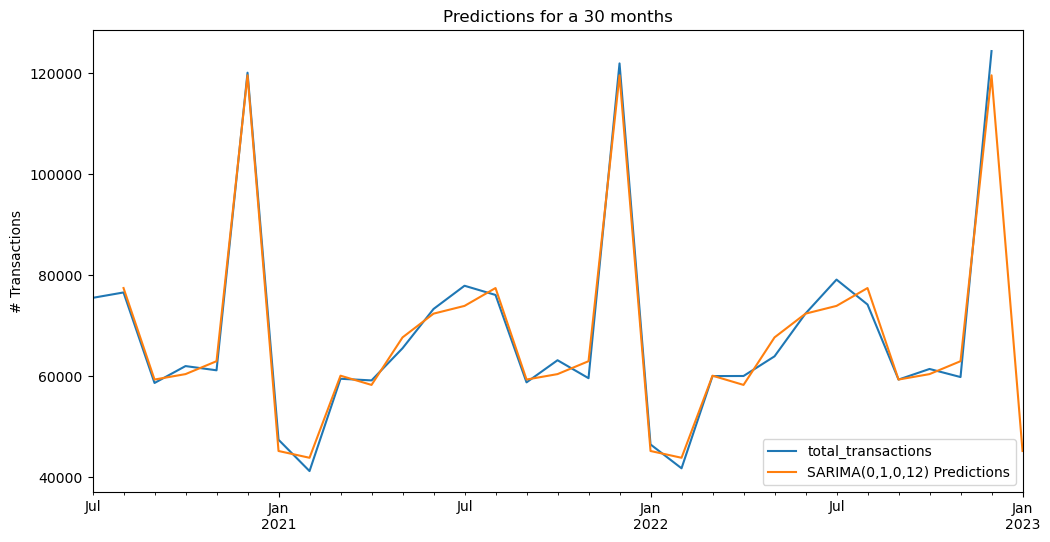

In [19]:
# Plot predictions against known values
title = 'Predictions for a 30 months'
ylabel='# Transactions'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
monthly_predictions.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate model

In [20]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, monthly_predictions)
print(f'SARIMA(0,1,0,12) MSE Error: {error:11.10}')

SARIMA(0,1,0,12) MSE Error: 1.004165495e+09


In [22]:
# from statsmodels.tools.eval_measures import rmse
# error = rmse(test, monthly_predictions)
# print(f'RMSE Error: {error:11.10}')

### Forecast the future

** RETRAIN ON ALL DATA **

In [23]:
model = SARIMAX(monthly_transactions,seasonal_order=(0,1,0,12))  
results = monthly_model.fit()
fcast = results.predict(len(monthly_transactions),len(monthly_transactions)+12,typ='levels').rename('SARIMA(0,1,0,12) Forecast')
# forecasting for 12 months

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


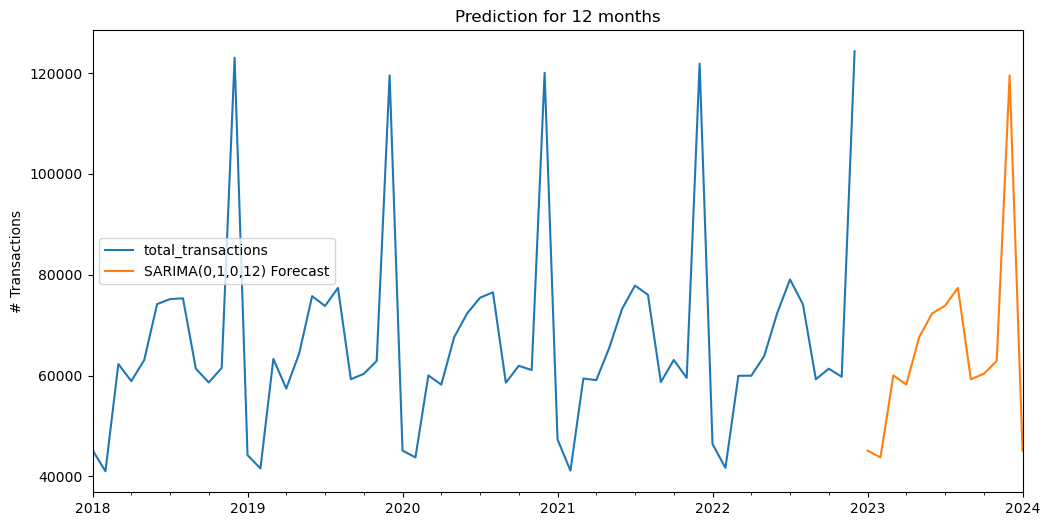

In [24]:
# Plot predictions against known values
title = 'Prediction for 12 months'
ylabel='# Transactions'
xlabel=''

ax = monthly_transactions.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors - SARIMAX

Adding in a useful external feature
SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous factors. It is an extension of the seasonal ARIMA (SARIMA) model that allows for the inclusion of additional exogenous variables, also known as covariates or regressors, in the forecasting process.

The SARIMAX model incorporates both the seasonal and non-seasonal components of ARIMA, while also considering the impact of external factors on the time series being forecasted. These external factors could be other time series variables, indicators, or predictors that may influence the target variable.

The general equation for a SARIMAX(p, d, q)(P, D, Q)s model with \( k \) exogenous variables can be expressed as:

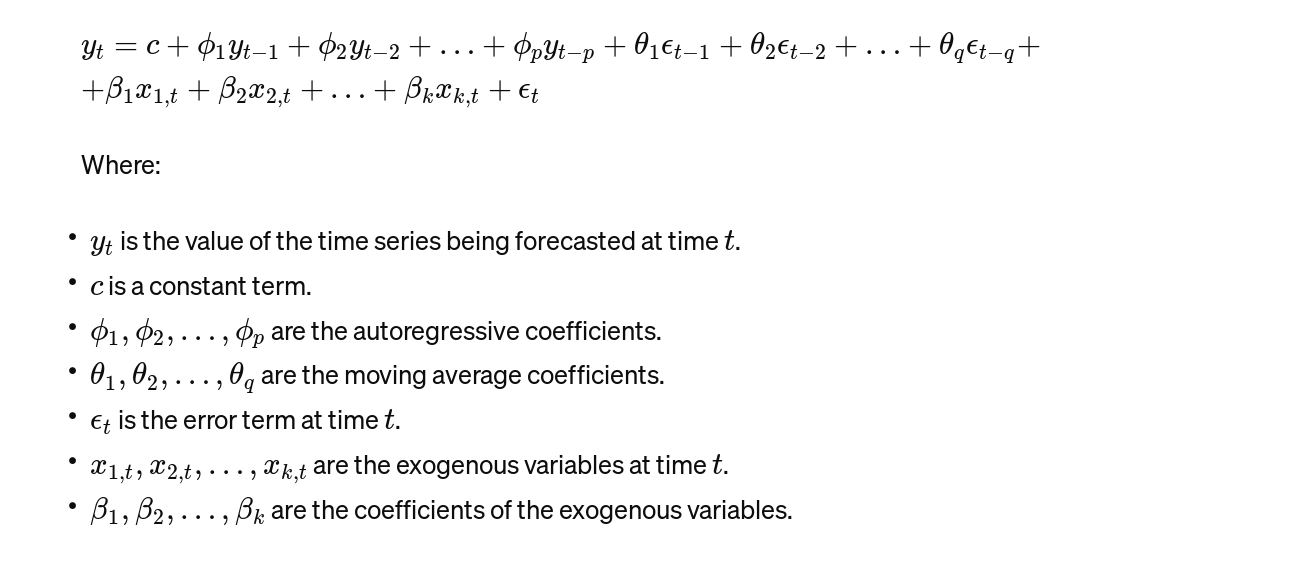

SARIMAX models are useful when there are known external factors that can improve the forecasting accuracy of the time series of interest. These external variables can capture additional information not accounted for by the ARIMA components alone, leading to more accurate predictions.

Estimation and inference in SARIMAX models involve fitting the model parameters, including both the ARIMA and exogenous variables coefficients, typically using maximum likelihood estimation or other optimization techniques. These models can be particularly powerful in scenarios where the behavior of the time series is influenced by both internal dynamics and external factors.

In [25]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
#df = pd.read_csv('data/RestaurantVisitors.csv',index_col='date',parse_dates=True)


In [26]:
monthly_transactions.index.freq = 'MS'

In [27]:
monthly_transactions.head()

,total_transactions
trans_month,
2018-01-01,45218
2018-02-01,41033
2018-03-01,62296
2018-04-01,58907
2018-05-01,63069


In [28]:
monthly_transactions.tail()

,total_transactions
trans_month,
2022-08-01,74129
2022-09-01,59272
2022-10-01,61371
2022-11-01,59770
2022-12-01,124305


[Text(0.5, 0, ''), Text(0, 0.5, 'Transactions per day')]

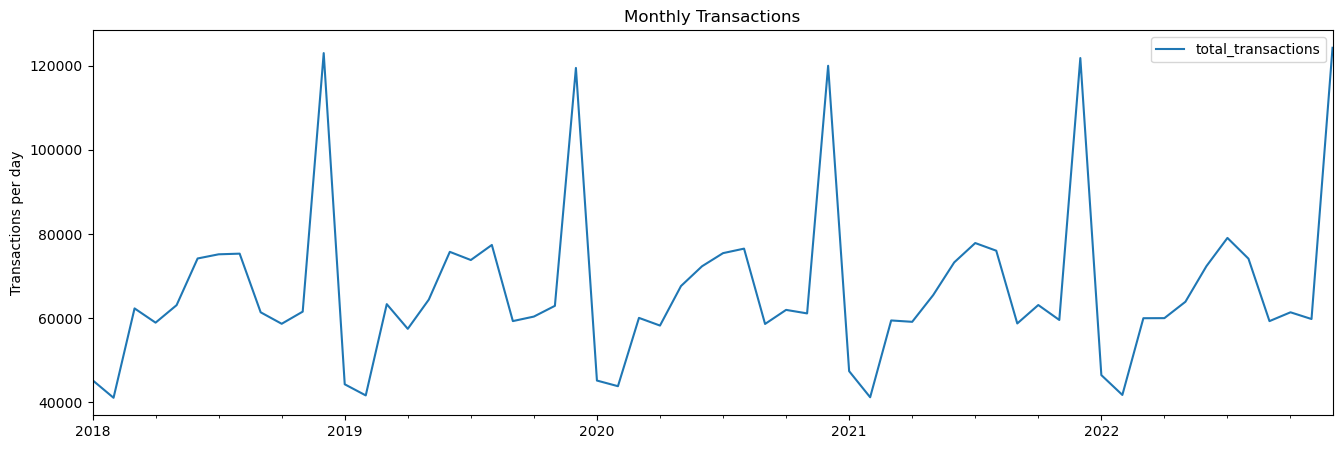

In [29]:
title='Monthly Transactions'
ylabel='Transactions per day'
xlabel='' # we don't really need a label here

ax = monthly_transactions.plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


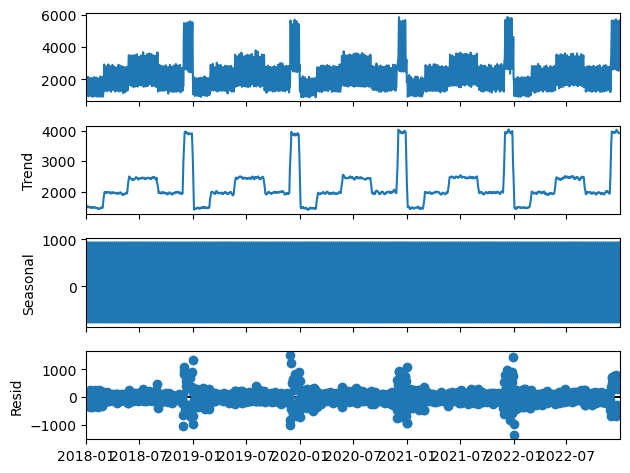

In [30]:
result = seasonal_decompose(daily_transactions)
result.plot();